# Quick Start Guide for `webbpsf_ext` 

Learn the basics for generating coefficients to quickly generate JWST PSFs.

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
import webbpsf_ext
from astropy.io import fits

# NIRCam Imaging Example

This notebook performs the following tasks:
1. initialize a simple NIRCam imaging setup
2. configure the PSF parameters
3. generate the baseline PSF coefficients
4. generate the field-dependent coefficients
5. generate WFE drift coefficients

In [3]:
# Init NIRCam instrument class
# A subclass of the WebbPSF NIRCam class
# Set fov_pix=33 for illustrative purposes
inst = webbpsf_ext.NIRCam_ext(filter='F430M', fov_pix=257, oversample=4)

[   webbpsf:INFO] NIRCam aperture name updated to NRCA1_FULL
[   webbpsf:INFO] NIRCam pixel scale switched to 0.063000 arcsec/pixel for the long wave channel.
[   webbpsf:INFO] NIRCam aperture name updated to NRCA5_FULL


In [4]:
# fov_pix and oversample are saved to class attributes.
# If modified, PSF coefficients must be regenerated.
print("fov_pix:", inst.fov_pix)
print("oversample:", inst.oversample)

fov_pix: 257
oversample: 4


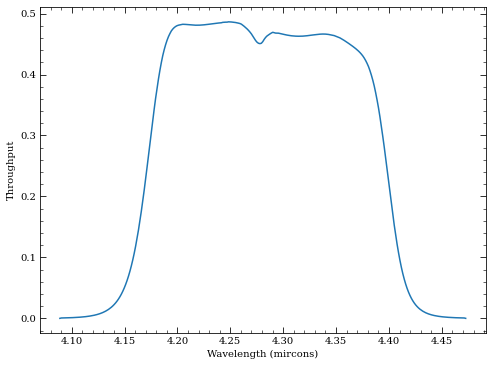

In [5]:
# Filter bandpass throughput is accessisble via the `bandpass` attribute as a pysynphot object
plt.plot(inst.bandpass.wave / 1e4, inst.bandpass.throughput)
plt.xlabel('Wavelength (mircons)')
plt.ylabel('Throughput');

## Generate WFE coefficients

Instead of saving a library of monochromatic PSFs, `webbpsf_ext` generates a series of PSFs over the instrument module band and fits Legendre polynomials to each pixel element. These coefficient images are then saved to disk either in a pre-specified directory, or in a new subdirectory within WebbPSF's data directory. The coefficients can then be reloaded for future use and arbitrary monochromatic PSFs quickly generated throughout the instrument wavelength range (and subsequently weighted by the throughput curve). This means that we only have to generate a single PSF coefficient that is useable for all filters within a given NIRCam module, for instance.

By default, we perform fits to the entire wavelength range for NIRCam medium and wideband filters in a given module (SW/LW). However, the polynomials don't perfectly represent the variation throughout large wavelength ranges, so the PSF wings sometime won't have the same sharp contrast levels as raw PSFs. This can be alleviated by instead performing per-filter fits by setting `inst.quick=True`. This is the default for narrowband filters as well as MIRI.

All PSFs are generated using the WebbPSF options `add_distortion=True` for those versions of WebbPSF that include the distortion fix (https://github.com/spacetelescope/webbpsf/pull/429). If this hasn't been implemented on your local copy, then `add_distortion=False` to prevent excruciatingly slow PSF calculations.

In [6]:
# Generate the PSF coefficients
inst.gen_psf_coeff()

[webbpsf_ext:INFO] Loading /Users/Jarron/NIRCam/webbpsf_ext_data/psf_coeffs/NIRCam/LWA_CLEAR_NONE_pix257_os4_jsig3_r0.00_th+0.0_RevWslice0_siwfe_legendre.fits


/Users/jarron/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2957: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


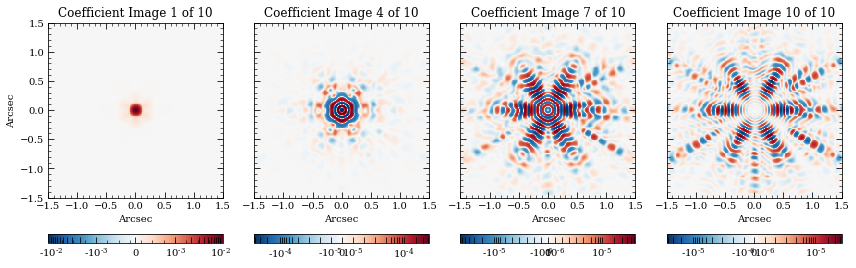

In [7]:
# Coefficients are accssible at inst.psf_coeff and header at inst.psf_coeff_header
from matplotlib.colors import LogNorm, SymLogNorm

fig, axes = plt.subplots(1,4, figsize=(12,4.5), sharey=True)
axes = axes.flatten()

extent = 0.5 * np.array([-1,1,-1,1]) * inst.fov_pix * inst.pixelscale
xy_lim = np.array([-1,1]) * 1.5
for i, ax in enumerate(axes):
    j = i*3
    im_cf = inst.psf_coeff[j]
    # Symmetric log normalization
    vmax = im_cf.max()
    norm = SymLogNorm(vmax/10, vmin=-1*vmax, vmax=vmax, base=10)
    imax = ax.imshow(im_cf, extent=extent, norm=norm, cmap='RdBu_r')
    fig.colorbar(imax, ax=ax, orientation='horizontal', pad=0.12)
    
    ax.set_xlabel('Arcsec')
    if i==0: ax.set_ylabel('Arcsec')
    
    ax.set_xlim(xy_lim)
    ax.set_ylim(xy_lim)
    
    ax.xaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])
    
    ax.set_title(f"Coefficient Image {j+1} of {len(inst.psf_coeff)}")
    
fig.tight_layout()

## Generate PSFs

A PSF is then created using the `isnt.calc_psf_from_coeff()` function. 

In [8]:
hdul = inst.calc_psf_from_coeff(return_oversample=True)

In [9]:
sp = webbpsf_ext.stellar_spectrum('flat')
webbpsf_ext.setup_logging('WARN', verbose=False)
hdul_webbpsf = inst.calc_psf(source=sp, fov_pixels=inst.fov_pix, oversample=inst.oversample)
webbpsf_ext.setup_logging('INFO', verbose=False)

[     poppy:WARNING] synphot unavailable (or invalid source supplied)! Assuming flat # of counts versus wavelength.
[     poppy:WARNING] CAUTION: Just interpolating rather than integrating filter profile, over 9 steps


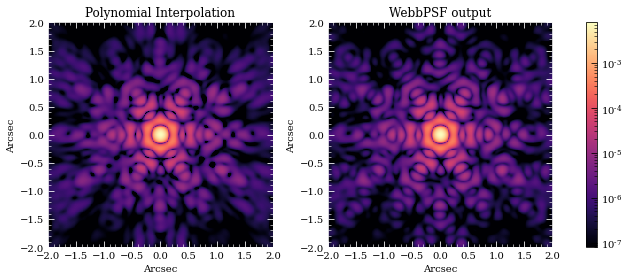

In [10]:
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(1,2, figsize=(10,4))
vmax = hdul[0].data.max()
norm = LogNorm(vmin=vmax/1e5, vmax=vmax)

extent = 0.5 * np.array([-1,1,-1,1]) * inst.fov_pix * inst.pixelscale
xy_lim = np.array([-1,1]) * 2
for i, im_psf in enumerate([hdul[0].data, hdul_webbpsf[2].data]):
    ax = axes[i]
    pos = ax.imshow(im_psf, norm=norm, extent=extent, cmap='magma')

    ax.set_xlim(xy_lim)
    ax.set_ylim(xy_lim)
    
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')
    
    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')
    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    
axes[0].set_title('Polynomial Interpolation')
axes[1].set_title('WebbPSF output')

fig.tight_layout()

cb = fig.colorbar(pos, ax=axes.ravel().tolist())

In the above example, there is some lost resolution in the faint regions of the PSF wings. This is because we chose to fit coefficients over a broad wavelength range, so regions that have large wavelength variations become noticeably smoothed. Normally, this level of variation falls well below the photon and detector noise, so it makes little practical difference. However, if these contrasts are important, you can set `inst.quick=True`, which will calculate coefficients over a narrower wavelength range specific to this filter's bandpass. This parameter defaults to True for all MIRI filters as well as NIRCam's narrow bandpasses. Another option is to increase the `inst.ndeg` from the default to include higher order polynomials in the fitting process.

You can also pass a `pysynphot` spectral objects, which provides different wavelength weighting to the resulting PSF based on the input SED.

In [11]:
# Various spectral types renormalized to 1 e-/sec
bp = inst.bandpass
sp_A0V = webbpsf_ext.stellar_spectrum('A0V', bp.unit_response(), 'flam', bp)
sp_G0V = webbpsf_ext.stellar_spectrum('G0V', bp.unit_response(), 'flam', bp)
sp_M0V = webbpsf_ext.stellar_spectrum('M0V', bp.unit_response(), 'flam', bp)

In [12]:
%%time

# PSFs of each
hdul_A0V = inst.calc_psf_from_coeff(sp=sp_A0V)
hdul_G0V = inst.calc_psf_from_coeff(sp=sp_G0V)
hdul_M0V = inst.calc_psf_from_coeff(sp=sp_M0V)

for hdul in [hdul_A0V, hdul_G0V, hdul_M0V]:
    print("Total flux:", hdul[0].data.sum())
    
# Calculate differences between PSFs (spectral type mismatches)
diff_AmG = hdul_A0V[0].data - hdul_G0V[0].data
diff_GmM = hdul_G0V[0].data - hdul_M0V[0].data
diff_AmM = hdul_A0V[0].data - hdul_M0V[0].data

Total flux: 0.9920012678500717
Total flux: 0.9920013595731302
Total flux: 0.9920088731928763
CPU times: user 2.19 s, sys: 392 ms, total: 2.58 s
Wall time: 820 ms


In [13]:
%%time 

# Compare to raw WebbPSF outputs (not relying on polynomial interpolation)
webbpsf_ext.setup_logging('WARN', verbose=False)
hdul_A0V_wpsf = inst.calc_psf(source=sp_A0V, fov_pixels=inst.fov_pix, oversample=inst.oversample)
hdul_G0V_wpsf = inst.calc_psf(source=sp_G0V, fov_pixels=inst.fov_pix, oversample=inst.oversample)
hdul_M0V_wpsf = inst.calc_psf(source=sp_M0V, fov_pixels=inst.fov_pix, oversample=inst.oversample)
webbpsf_ext.setup_logging('INFO', verbose=False)

ext = 2  # Oversampled and distorted PSF
for hdul in [hdul_A0V_wpsf, hdul_G0V_wpsf, hdul_M0V_wpsf]:
    print("Total flux:", hdul[ext].data.sum())

diff_AmG_wpsf = hdul_A0V_wpsf[ext].data - hdul_G0V_wpsf[ext].data
diff_GmM_wpsf = hdul_G0V_wpsf[ext].data - hdul_M0V_wpsf[ext].data
diff_AmM_wpsf = hdul_A0V_wpsf[ext].data - hdul_M0V_wpsf[ext].data

[     poppy:WARNING] synphot unavailable (or invalid source supplied)! Assuming flat # of counts versus wavelength.
[     poppy:WARNING] CAUTION: Just interpolating rather than integrating filter profile, over 9 steps
[     poppy:WARNING] synphot unavailable (or invalid source supplied)! Assuming flat # of counts versus wavelength.
[     poppy:WARNING] CAUTION: Just interpolating rather than integrating filter profile, over 9 steps
[     poppy:WARNING] synphot unavailable (or invalid source supplied)! Assuming flat # of counts versus wavelength.
[     poppy:WARNING] CAUTION: Just interpolating rather than integrating filter profile, over 9 steps


Total flux: 0.9917282810754945
Total flux: 0.9917282810754945
Total flux: 0.9917282810754945
CPU times: user 25.7 s, sys: 1.54 s, total: 27.2 s
Wall time: 10.8 s


__Note (04/06/2021)__: The latest development version of WebbPSF has switched from `pysynphot` to the new `synphot` https://synphot.readthedocs.io/en/latest/, whereas `webbpsf_ext` still uses the former for calculating spectra. Since we can no longer pass pysynphot spectra directly to WebbPSF's `calc_psf` function, it defaults to all flat spectra, so there is no apparent color difference between those three PSFs in the above image. Future versions of this notebook will fix that issue once we update to the `synphot` version in `webbpsf_ext`.

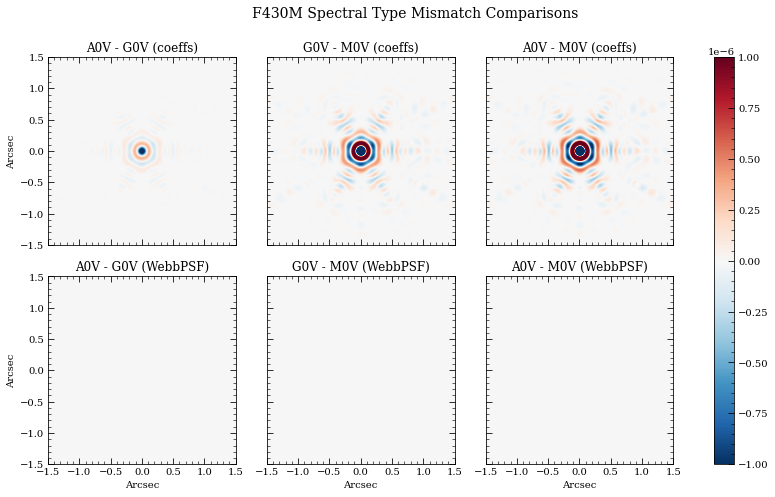

In [14]:
# Compare the spectral type PSF differences for polynomial interpolation vs WebbPSF raw PSFs
fig, axes = plt.subplots(2,3, figsize=(12,7), sharey=True, sharex=True)

extent = 0.5 * np.array([-1,1,-1,1]) * inst.fov_pix * inst.pixelscale
vmin, vmax = np.array([-1,1])*1e-6

# Top plots 
im_list = [diff_AmG, diff_GmM, diff_AmM]
titles = ['A0V - G0V (coeffs)', 'G0V - M0V (coeffs)', 'A0V - M0V (coeffs)']
for i, im in enumerate(im_list):
    ax = axes[0,i]    
    ax.imshow(im, extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    ax.set_title(titles[i])

im_list = [diff_AmG_wpsf, diff_GmM_wpsf, diff_AmM_wpsf]
titles = ['A0V - G0V (WebbPSF)', 'G0V - M0V (WebbPSF)', 'A0V - M0V (WebbPSF)']
for i, im in enumerate(im_list):
    ax = axes[1,i]    
    pos = ax.imshow(im, extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    ax.set_title(titles[i])
    
# Labels and stuff
xy_lim = np.array([-1,1]) * 1.5
for i, ax in enumerate(axes.flatten()):    
    if i>2: ax.set_xlabel('Arcsec')
    if i % 3 == 0: ax.set_ylabel('Arcsec')
        
    ax.set_xlim(xy_lim)
    ax.set_ylim(xy_lim)

    ax.xaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])
    
fig.suptitle(f'{inst.filter} Spectral Type Mismatch Comparisons', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

# Add colorbar
cb = fig.colorbar(pos, ax=axes.ravel().tolist())

## SI WFE Variations

JWST instruments have field-dependent wavefront variations due to static aberrations within the instruments. See https://webbpsf.readthedocs.io/en/latest/jwst.html#si-wfe. In order to accommodate these changes, we calculate the coefficients for each known position, then use a Regular Grid Interpolator to capture the variations in the coefficients across the instrument field of view. These variations are calculated and saved by calling `inst.gen_wfefield_coeff()`. Depending on the size of your PSF, the calculation may take some time, but you only have to this once for a given PSF size and oversampling.

In [15]:
inst.gen_wfefield_coeff()

[webbpsf_ext:INFO] Loading /Users/Jarron/NIRCam/webbpsf_ext_data/psf_coeffs/NIRCam/LWA_CLEAR_NONE_pix129_os4_jsig3_r0.00_th+0.0_RevWslice0_siwfe_legendre_wfefields.npz


In [16]:
# Generate a series of PSFs at various detector pixel locations
coords = np.array([(10,10), (10,2000), (2000,2000), (2000,10)])
hdul_psfs = inst.calc_psf_from_coeff(coord_vals=coords.transpose(), coord_frame='sci')

[webbpsf_ext:INFO] Generating field-dependent modifications...


PSFs:   0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
# Compare to raw WebbPSF output
psfs_raw = []

webbpsf_ext.setup_logging('WARN', verbose=False)
det_pos_orig = inst.detector_position
for det_pos in tqdm(coords):
    inst.detector_position = det_pos
    hdul = inst.calc_psf(fov_pixels=inst.fov_pix, oversample=inst.oversample)
    psfs_raw.append(hdul[2]) # Only want oversampled distorted imge

# Return to original values
inst.detector_position = det_pos_orig
webbpsf_ext.setup_logging('INFO', verbose=False)

hdul_psfs_raw = fits.HDUList(psfs_raw)

  0%|          | 0/4 [00:00<?, ?it/s]

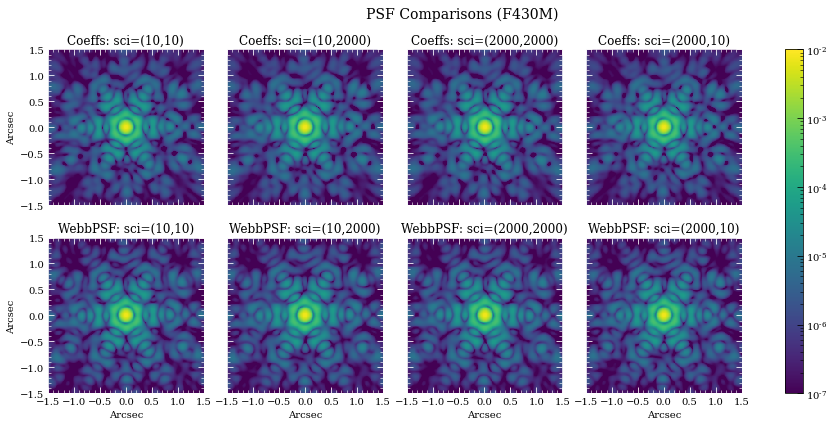

In [18]:
from matplotlib.colors import SymLogNorm, LogNorm
fig, axes = plt.subplots(2,4,figsize=(13,6), sharey=True, sharex=True)

extent = 0.5 * np.array([-1,1,-1,1]) * inst.fov_pix * inst.pixelscale

norm=LogNorm(vmin=1e-7, vmax=1e-2)
for i, hdu in enumerate(hdul_psfs):
    ax = axes[0,i]
    pos = ax.imshow(hdu.data, extent=extent, norm=norm)
    xv, yv = coords[i]
    ax.set_title('Coeffs: sci=({:.0f},{:.0f})'.format(xv, yv))

for i, hdu in enumerate(hdul_psfs_raw):
    ax = axes[1,i]
    pos = ax.imshow(hdu.data, extent=extent, norm=norm)
    xv, yv = coords[i]
    ax.set_title('WebbPSF: sci=({:.0f},{:.0f})'.format(xv, yv))
    
xylim = np.array([-1,1]) * 1.5
for i, ax in enumerate(axes.flatten()):
    if i>3: ax.set_xlabel('Arcsec')
    if i % 4 == 0: ax.set_ylabel('Arcsec')
        
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')

    ax.xaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])
    
fig.suptitle(f'PSF Comparisons ({inst.filter})', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

cb = fig.colorbar(pos, ax=axes.ravel().tolist())

In [19]:
hdul0 = inst.calc_psf_from_coeff()

webbpsf_ext.setup_logging('WARN', verbose=False)
hdul0_raw = inst.calc_psf(fov_pixels=inst.fov_pix, oversample=inst.oversample)
webbpsf_ext.setup_logging('INFO', verbose=False)

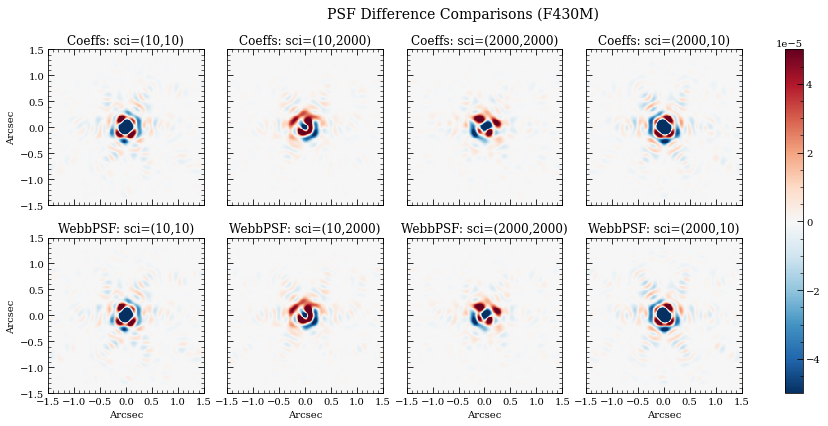

In [20]:
from matplotlib.colors import SymLogNorm, LogNorm
fig, axes = plt.subplots(2,4,figsize=(13,6), sharey=True, sharex=True)

extent = 0.5 * np.array([-1,1,-1,1]) * inst.fov_pix * inst.pixelscale

vmin, vmax = np.array([-1,1])*5e-5
for i, hdu in enumerate(hdul_psfs):
    ax = axes[0,i]
    imdiff = hdu.data - hdul0[0].data
    pos = ax.imshow(imdiff, extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    xv, yv = coords[i]
    ax.set_title('Coeffs: sci=({:.0f},{:.0f})'.format(xv, yv))

for i, hdu in enumerate(hdul_psfs_raw):
    ax = axes[1,i]
    imdiff = hdu.data - hdul0_raw[0].data
    pos = ax.imshow(imdiff, extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    xv, yv = coords[i]
    ax.set_title('WebbPSF: sci=({:.0f},{:.0f})'.format(xv, yv))
    
xylim = np.array([-1,1]) * 1.5
for i, ax in enumerate(axes.flatten()):
    if i>3: ax.set_xlabel('Arcsec')
    if i % 4 == 0: ax.set_ylabel('Arcsec')
        
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)

    ax.xaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])
    
fig.suptitle(f'PSF Difference Comparisons ({inst.filter})', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

cb = fig.colorbar(pos, ax=axes.ravel().tolist())

## WFE Drift

JWST's OPD is expected to drift over time with respect to the thermal state of the telescope, primarily due to changes spacecraft's solar elongation angle. There are three primary components that result in characteristic modifications to Zernike components:

 1. Thermal stresses to the OTE backplane
 2. Frill tensioning on the primary mirror
 3. IEC heater state (on/off) changes.

Similar to the field-dependent coefficient offsets, we attempts to parameterize how the PSF changes in a simplistic way by modifying the OPD for a typical slew maneuver. This is "simple" in the sense that we always use the same recipe to create drifted PSFs. More comprehensive drift scenarios at fine-grained time increments can be generated using the ``OTE_WFE_Drift_Model`` class in `opds.py`, but this requires on-the-fly PSF creation using WebbPSF's inherent `calc_psf` function; this will be covered in an advanced utilities notebook.

A typical use case would be to create two PSFs with some WFE drift (specified in nm RMS), subtract the two PSFs, and determine the contrast with respect to separation.

In [21]:
inst.gen_wfedrift_coeff()

[webbpsf_ext:INFO] Loading /Users/Jarron/NIRCam/webbpsf_ext_data/psf_coeffs/NIRCam/LWA_CLEAR_NONE_pix257_os4_jsig3_r0.00_th+0.0_RevWslice0_siwfe_legendre_wfedrift.npz


In [22]:
wfe_drift_list = [0, 2, 5, 10]

In [23]:
psf_over_list = []

for wfe_drift in tqdm(wfe_drift_list):
    psf_over = inst.calc_psf_from_coeff(wfe_drift=wfe_drift, return_oversample=True)
    psf_over_list.append(psf_over[0])
    
hdul_psfs = fits.HDUList(psf_over_list)

  0%|          | 0/4 [00:00<?, ?it/s]

[webbpsf_ext:INFO] Generating WFE drift modifications...
[webbpsf_ext:INFO] Generating WFE drift modifications...
[webbpsf_ext:INFO] Generating WFE drift modifications...


In [24]:
# Compare to raw WebbPSF output
psfs_raw = []

webbpsf_ext.setup_logging('WARN', verbose=False)
pupilopd_orig = inst.pupilopd
pupil_orig    = inst.pupil
for wfe_drift in tqdm(wfe_drift_list):
    wfe_dict = inst.drift_opd(wfe_drift)
    opd_new = wfe_dict['opd']
    inst.pupilopd = opd_new
    inst.pupil    = opd_new
    hdul = inst.calc_psf(fov_pixels=inst.fov_pix, oversample=inst.oversample)
    psfs_raw.append(hdul[2]) # Only want oversampled distorted imge

# Return to original values
inst.pupilopd = pupilopd_orig
inst.pupil    = pupil_orig
webbpsf_ext.setup_logging('INFO', verbose=False)

hdul_psfs_raw = fits.HDUList(psfs_raw)

  0%|          | 0/4 [00:00<?, ?it/s]

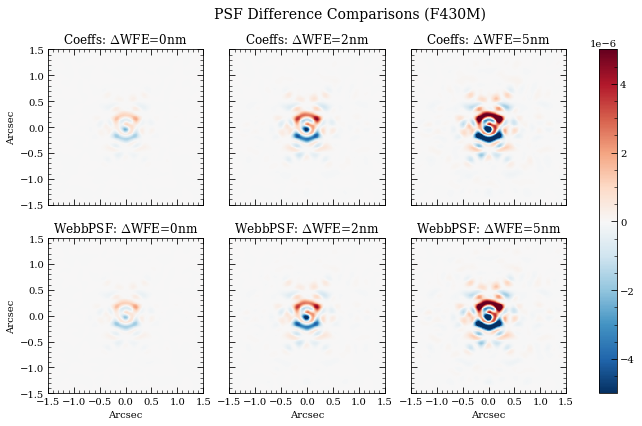

In [25]:
from matplotlib.colors import SymLogNorm, LogNorm
fig, axes = plt.subplots(2,3,figsize=(10,6), sharey=True, sharex=True)

extent = 0.5 * np.array([-1,1,-1,1]) * inst.fov_pix * inst.pixelscale

vmin, vmax = np.array([-1,1])*5e-6
for i, hdu in enumerate(hdul_psfs[1:]):
    ax = axes[0,i]
    imdiff = hdu.data - hdul_psfs[0].data
    pos = ax.imshow(imdiff, extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    ax.set_title('Coeffs: $\Delta$WFE={}nm'.format(wfe_drift_list[i]))

for i, hdu in enumerate(hdul_psfs_raw[1:]):
    ax = axes[1,i]
    imdiff = hdu.data - hdul_psfs_raw[0].data
    pos = ax.imshow(imdiff, extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    ax.set_title('WebbPSF: $\Delta$WFE={}nm'.format(wfe_drift_list[i]))
    
xylim = np.array([-1,1]) * 1.5
for i, ax in enumerate(axes.flatten()):
    if i>2: ax.set_xlabel('Arcsec')
    if i % 3 == 0: ax.set_ylabel('Arcsec')
        
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)

    ax.xaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])
    
fig.suptitle(f'PSF Difference Comparisons ({inst.filter})', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

cb = fig.colorbar(pos, ax=axes.ravel().tolist())

In [26]:
def do_contrast(hdu1, hdu2, nsig=5, supersample=True, func=np.std):
    
    from webbpsf_ext.maths import radial_std, frebin

    im1 = hdu1.data
    im2 = hdu2.data
    header = hdu1.header
    
    data = im1 - im2
    
    pixscale = header['PIXELSCL']
    oversample = header['OVERSAMP']
    rr, stds = radial_std(data, pixscale=pixscale, oversample=oversample, supersample=supersample, func=func)

    imavg = (im1+im2)/2
    if supersample or oversample==1:
        psf_max = imavg.max()
    else:
        psf_max = frebin(imavg, scale=1/oversample).max()

    return rr, nsig*stds/psf_max

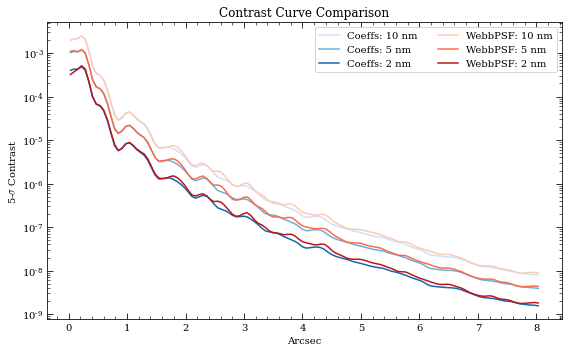

In [27]:
from webbpsf_ext import robust

fig, ax = plt.subplots(1,1, figsize=(8,5))

lin_vals = np.linspace(0.2,0.8,len(wfe_drift_list)-1)
c1 = plt.cm.Blues_r(lin_vals)[::-1]
c2 = plt.cm.Reds_r(lin_vals)[::-1]

wfe_rev = wfe_drift_list[1:][::-1]
hdu_list_rev = hdul_psfs[1:][::-1]
for i, hdu in enumerate(hdu_list_rev):
    rr, cont = do_contrast(hdu, hdul_psfs[0], nsig=5, supersample=False, func=robust.std)
    ax.semilogy(rr, cont, color=c1[i], label='Coeffs: {} nm'.format(wfe_rev[i]))

hdu_list_rev = hdul_psfs_raw[1:][::-1]
for i, hdu in enumerate(hdu_list_rev):
    rr, cont = do_contrast(hdu, hdul_psfs_raw[0], nsig=5, supersample=False, func=robust.std)
    ax.semilogy(rr, cont, color=c2[i], label='WebbPSF: {} nm'.format(wfe_rev[i]))

ax.legend(ncol=2)
ax.set_xlabel('Arcsec')
ax.set_ylabel('5-$\sigma$ Contrast')

ax.set_title('Contrast Curve Comparison')

fig.tight_layout()

Contrast curves between those PSFs derived via the polynomial coefficient method very closely match those calculated using WebbPSF's standard functions.